In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
tr = pd.read_csv('X_train.csv')
te = pd.read_csv('X_test.csv')
target = pd.read_csv('y_train.csv')
ss = pd.read_csv('sample_submission.csv')

In [3]:
tr.head()   

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
tr.shape, te.shape

((487680, 13), (488448, 13))

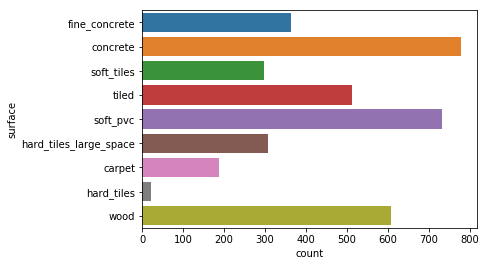

In [5]:
sns.countplot(y = 'surface', data = target)
plt.show()

In [6]:
len(tr.measurement_number.value_counts())    #each series has 128 measurements(each measurement has 10 sensor measurements)

128

In [7]:
tr.shape[0] / 128, te.shape[0] / 128       

(3810.0, 3816.0)

# converts Quaternions to Euler angles 

## https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1

## https://www.cnblogs.com/rainbow70626/p/5348725.html

In [8]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [9]:
def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz, = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
        
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 0.5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    def d1(x):
        return np.mean(np.abs(np.diff(x)))
    def d2(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue   #
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + ' _max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        
    return new

In [10]:
%%time
tr = fe(tr)
te = fe(te)

Wall time: 46.4 s


In [11]:
tr.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X _max_to_min,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,orientation_Y_min,orientation_Y_max,...,angle_vs_acc _max_to_min,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel _max_to_min,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.75953,0.75822,-0.634008,-0.63456,-0.63306,...,1.766897,0.445076,0.251897,71.253309,19.504720,298.761364,44.060971,15.317388,298.761364,19.504720
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.95896,0.95837,0.241867,0.24074,0.24270,...,2.895188,0.491481,0.169758,33.584444,10.012514,142.881670,21.735220,14.270310,142.881670,10.012514
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.51434,0.50944,-0.846171,-0.84779,-0.84490,...,1.873654,0.517216,0.276047,66.487159,20.553513,355.472539,47.187945,17.294977,355.472539,20.553513
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.93968,0.93884,0.310140,0.30943,0.31147,...,10.097404,1.414912,0.140126,31.312458,5.580044,202.142335,30.470678,36.225941,202.142335,5.580044
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.89689,0.88673,0.428144,0.41646,0.43740,...,1.424239,0.369502,0.259438,19.904763,12.840288,32.676098,4.770065,2.544810,32.676098,12.840288


In [12]:
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])   
target['surface'].unique()

array([2, 1, 6, 7, 5, 4, 0, 3, 8], dtype=int64)

In [13]:
tr.fillna(0, inplace = True)
te.fillna(0, inplace = True) 

In [14]:
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)
te.replace(-np.inf, 0, inplace = True)
te.replace(np.inf, 0, inplace = True)    

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=8, shuffle=True, random_state=200)

In [16]:
sub_preds_rf = np.zeros((te.shape[0],9))     #surface有9个类？
oof_preds_rf = np.zeros((tr.shape[0]))
score = 0

-------------------- 0 --------------------
score  0.918918918918919


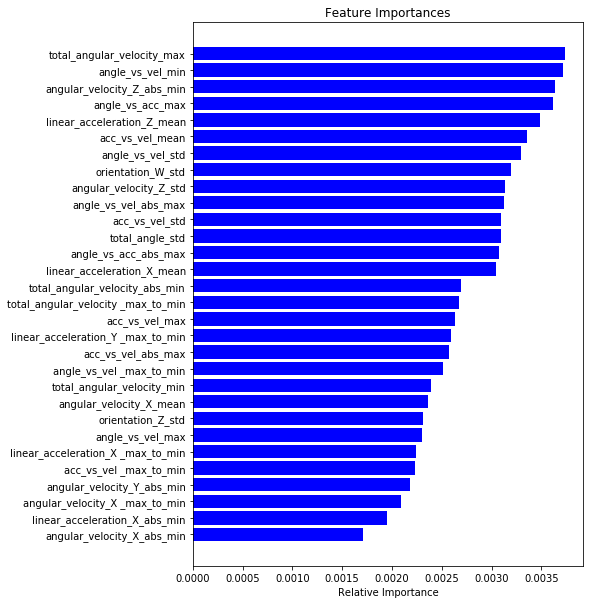

-------------------- 1 --------------------
score  0.9


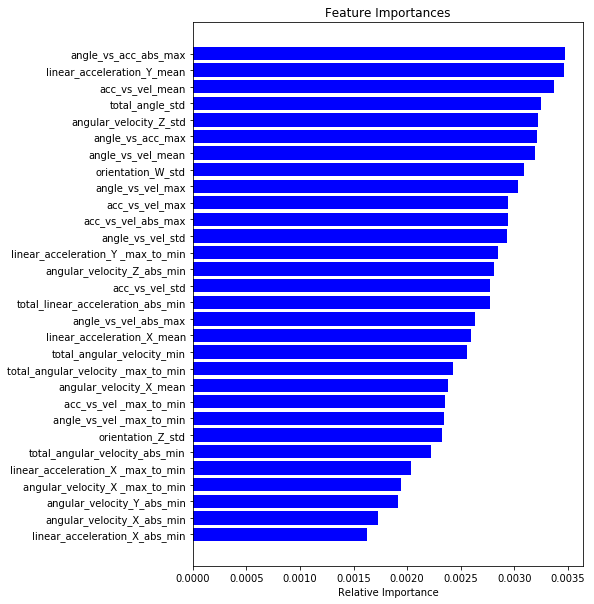

-------------------- 2 --------------------
score  0.8977035490605428


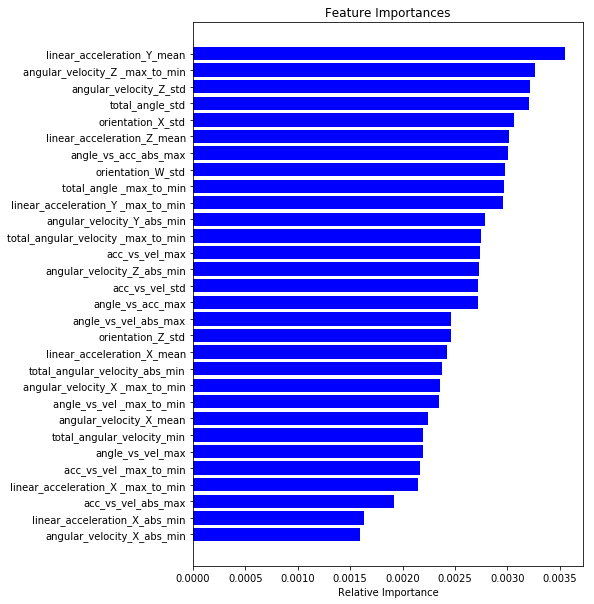

-------------------- 3 --------------------
score  0.9119496855345912


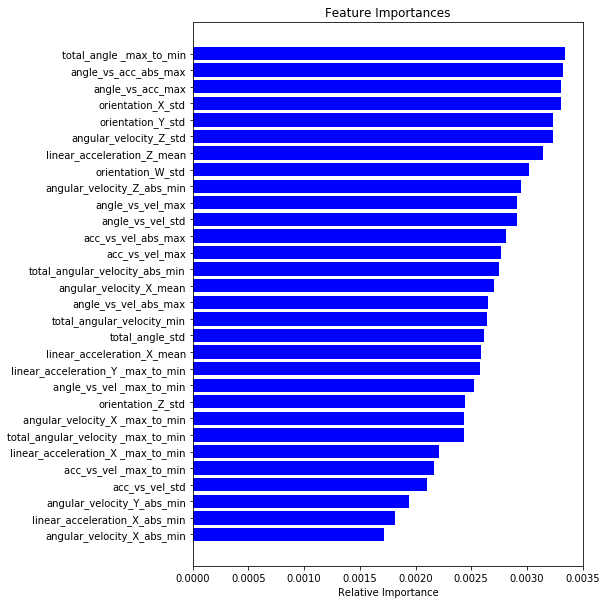

-------------------- 4 --------------------
score  0.92


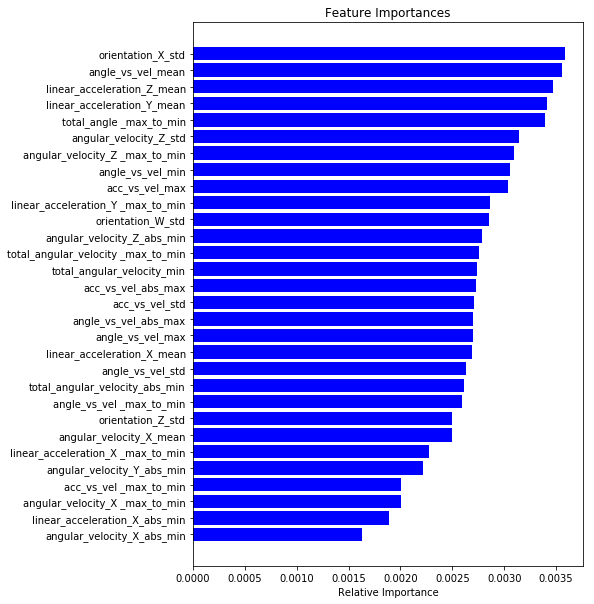

-------------------- 5 --------------------
score  0.9260042283298098


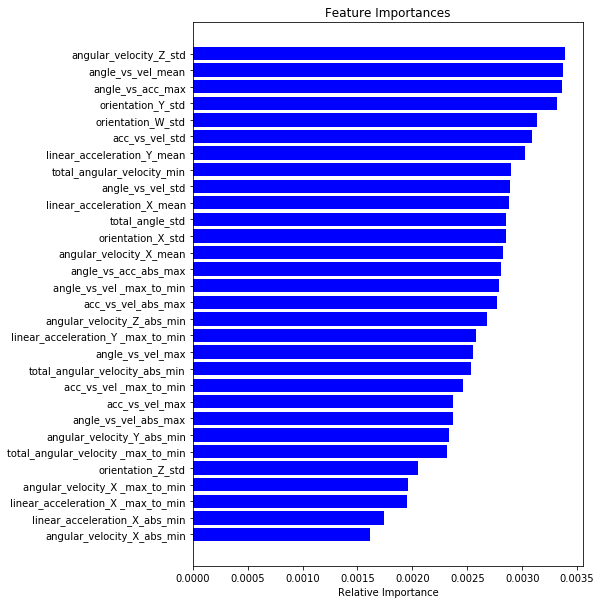

-------------------- 6 --------------------
score  0.9323467230443975


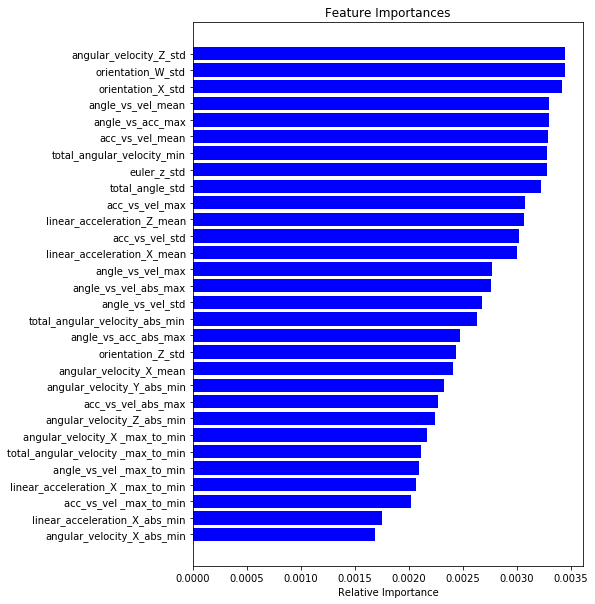

-------------------- 7 --------------------
score  0.8898305084745762


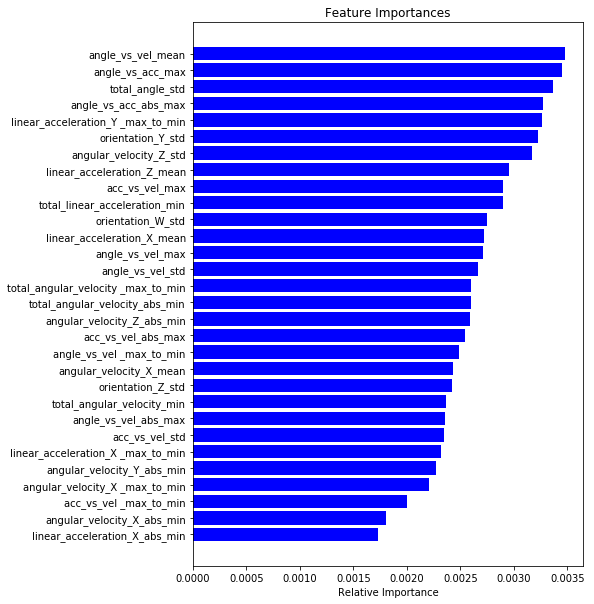

Avg Accuracy 0.9120942016703546


In [17]:
for i, (train_index, test_index) in enumerate(folds.split(tr, target['surface'])):
    #After constructing the cross-validation folds, the .split separation is required, 
    #and the split objects are the training set and the test set.
    print('-'*20, i, '-'*20 )  
    
    clf = RandomForestClassifier(n_estimators = 200, n_jobs = -1)    #Random forest classifier n_estimators is a number of decision trees
    clf.fit(tr.iloc[train_index], target['surface'][train_index])    
    oof_preds_rf[test_index] = clf.predict(tr.iloc[test_index])      #return the predict labels
    sub_preds_rf += clf.predict_proba(te) / folds.n_splits            
    score += clf.score(tr.iloc[test_index], target['surface'][test_index])
    print('score ', clf.score(tr.iloc[test_index], target['surface'][test_index]))
    
    importances = clf.feature_importances_     #Reflecting the influence of each feature, the greater the effect, the greater the effect of the feature
    indices = np.argsort(importances)
    features = tr.columns
    
    hm = 30
    plt.figure(figsize=(7,10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print('Avg Accuracy', score / folds.n_splits)

In [18]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive

import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

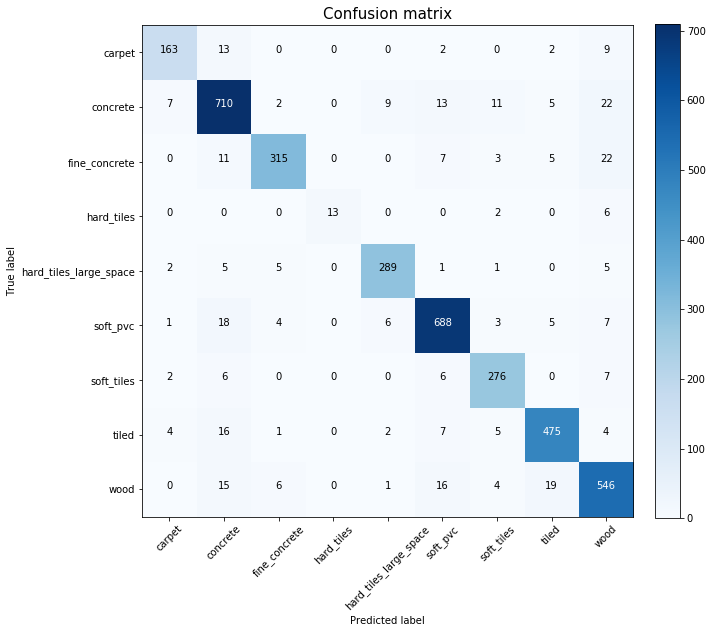

In [19]:
plot_confusion_matrix(target['surface'], oof_preds_rf, le.classes_)

In [20]:
ss['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
ss.to_csv('submission.csv', index=False)
ss.head(10)

C:\Users\control\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood
